<a href="https://colab.research.google.com/github/ahatesham02/Bangla-Image-Captioning/blob/main/Few_shot_3_learning_with_bornonImage_Captioning_with_Bahdanau_Attention_(Bidirectional_GRU)_Bancap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import keras
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.backend import set_session
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

!unzip -qq Flickr8k_Dataset.zip

In [ ]:
! pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import bnlp
from bnlp.corpus import  punctuations, letters, digits

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Thesis/Flicker8k Bangla/BAN-Cap_captiondata.csv')

FileNotFoundError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.head(15)

In [ ]:
def create_vocabulary(data):
  vocab = []
  for captions in data.bengali_caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [ ]:
vocabulary = create_vocabulary(data)

In [ ]:
table = str.maketrans('', '', punctuations)
desc = [w.translate(table) for w in data.bengali_caption]

In [ ]:
def cleaning(row):
  text = re.sub('[^\u0980-\u09FF]',' ', row) 
  return text

In [ ]:
data['bengali_caption'] = data.bengali_caption.apply(cleaning)

In [ ]:
data.head(10)

In [ ]:
clean_vocabulary = create_vocabulary(data)

In [ ]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Flicker8k_Dataset'
images = listdir(image_dir)

In [ ]:
def clean(col):
  text = col.split('#')[0]
  return text
  
  

In [ ]:
data2 = data.copy()

In [ ]:
data2.head(10)

In [ ]:
data2['caption_id'] = data2.caption_id.apply(lambda x : x.split('#')[0])

In [ ]:
data2.head(10)

In [ ]:
data[7000:7010]

In [ ]:
data2.shape

In [ ]:
data3 = data2[:40000]

In [ ]:
data3.shape

In [ ]:
def preprocess_images(data):
  img_name_vector = []

  for filenames in data3["caption_id"]:
      full_image_path = image_dir+"/"+ filenames
      img_name_vector.append(full_image_path)
  return img_name_vector
img_name_vector = preprocess_images(data)
img_name_vector[:10]

In [ ]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data3["bengali_caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data)
total_captions[:10]

In [ ]:
"""def data_limiter(num,total_captions,img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector"""

In [ ]:
#total_captions,img_name_vector = data_limiter(40000,total_captions,img_name_vector)

In [ ]:
len(total_captions)

In [ ]:
from pickle import dump

# save to file
dump(total_captions, open('bengali_captions.pkl', 'wb'))
dump(img_name_vector, open('bengali_img_names.pkl', 'wb'))

In [ ]:
from pickle import load

In [4]:
total_captions = load(open('/content/drive/MyDrive/Thesis/Flicker8k Bangla/Image Captioning Attention/BAN CAP/bancap_captions.pkl', 'rb'))
img_name_vector = load(open('/content/drive/MyDrive/Thesis/Flicker8k Bangla/Image Captioning Attention/BAN CAP/bancap_img_names.pkl', 'rb'))

In [5]:
len(img_name_vector)

40000

##Bornon Dataset

In [6]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [7]:
import zipfile
exfile= '/content/drive/MyDrive/Thesis/Bornon/Bornon Images-20221222T175856Z-001.zip'
zip_ref = zipfile.ZipFile(exfile, 'r')
zip_ref.extractall()
zip_ref.close()

In [8]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Bornon Images'
images = listdir(image_dir)

## The location of the caption file
descriptions_dir = '/content/drive/MyDrive/Thesis/Bornon/bornon_train_token.txt'
print("The number of jpg flies in Bornon: {}".format(len(images)))

The number of jpg flies in Bornon: 4106


## Bancap + Bornon (1000)

In [9]:
train_captions_bornon = load(open('/content/drive/MyDrive/Thesis/Bornon/bornon_captions.pkl', 'rb'))
img_name_vector_bornon = load(open('/content/drive/MyDrive/Thesis/Bornon/bornon_img_names.pkl', 'rb'))

In [10]:
len(img_name_vector_bornon)

20439

In [11]:
bornon_train, bornon_test, bornon_cap_train, bornon_cap_test = train_test_split(img_name_vector_bornon, train_captions_bornon, test_size = 0.1, random_state = 42)

In [12]:
len(bornon_train)

18395

In [13]:
len(bornon_train[:13794])

13794

In [14]:
train_captions1 = total_captions[:25000] + bornon_cap_train[:13794]
img_name_vector1 = img_name_vector[:25000] + bornon_train[:13794]

In [15]:
# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[1],img.shape))

In [16]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [17]:
for j in img_list:
  img_shape_finder(j)

Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the

In [18]:
import tensorflow as tf

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [20]:
image_model = ResNet50(include_top=False,weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output  
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

94765736/94765736 [==============================] - 3s 0us/step


In [21]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [22]:
preprocessed_image = []
IMAGE_SHAPE = (224, 224)

In [23]:
for img in img_name_vector1[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    preprocessed_image.append(img)

Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)


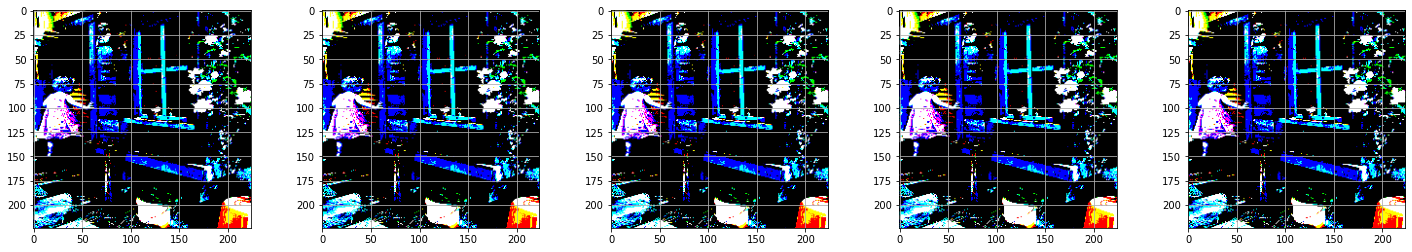

In [24]:
# checking first five images post preprocessing
Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)
for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')

Shape after resize : (224, 224, 3)


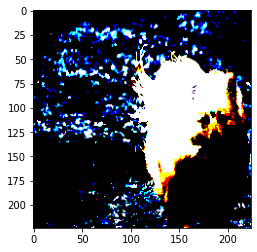

In [25]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img, image_path

img1,img1_path = load_images("Flicker8k_Dataset/3439243433_d5f3508612.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

In [26]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions1)
train_seqs = tokenizer.texts_to_sequences(train_captions1)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions1)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [27]:
vocab_size = len(tokenizer.index_word)+1

In [28]:
vocab_size

14324

In [29]:
train_captions1[:3]

['<start> একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে  <end>',
 '<start> একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে <end>',
 '<start> একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে   <end>']

In [30]:
train_seqs[:3]

[[2, 4, 263, 41, 28, 39, 47, 4, 648, 1087, 888, 837, 207, 167, 3],
 [2, 4, 47, 40, 4, 137, 5374, 3609, 3],
 [2, 4, 39, 25, 137, 3610, 167, 3]]

In [31]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'একটি',
 5: 'আছে',
 6: 'একজন',
 7: 'যাচ্ছে',
 8: 'কুকুর',
 9: 'দেখা',
 10: 'এক',
 11: 'লোক',
 12: 'করছে',
 13: 'এবং',
 14: 'সাদা',
 15: 'উপর',
 16: 'কালো',
 17: 'বসে',
 18: 'কিছু',
 19: 'দুটি',
 20: 'ও',
 21: 'মহিলা',
 22: 'খেলছে',
 23: 'ছেলে',
 24: 'লাল',
 25: 'তার',
 26: 'দিয়ে',
 27: 'ছোট',
 28: 'পরা',
 29: 'পাশে',
 30: 'রঙের',
 31: 'নীল',
 32: 'দাঁড়িয়ে',
 33: 'মধ্যে',
 34: 'মানুষ',
 35: 'নিয়ে',
 36: 'ছবি',
 37: 'সামনে',
 38: 'পরিহিত',
 39: 'বাচ্চা',
 40: 'শিশু',
 41: 'জামা',
 42: 'দৌড়াচ্ছে',
 43: 'পরে',
 44: 'ব্যক্তি',
 45: 'সবুজ',
 46: 'কুকুরটি',
 47: 'মেয়ে',
 48: 'দিকে',
 49: 'থেকে',
 50: 'দিচ্ছে',
 51: 'ধরে',
 52: 'লাফ',
 53: 'করে',
 54: 'দিয়ে',
 55: 'রয়েছে',
 56: 'দাঁড়িয়ে',
 57: 'ঘাসের',
 58: 'পানিতে',
 59: 'বাদামী',
 60: 'বল',
 61: 'নিয়ে',
 62: 'সাথে',
 63: 'এর',
 64: 'দুই',
 65: 'মাঠে',
 66: 'হলুদ',
 67: 'খাবার',
 68: 'অনেক',
 69: 'জন্য',
 70: 'লোকটি',
 71: 'হাতে',
 72: 'মুখে',
 73: 'দুজন',
 74: 'মেয়ে',
 75: 'বালক',
 76: 'উপরে'

In [32]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(38794, 34)


In [33]:
cap_vector

array([[   2,    4,  263, ...,    0,    0,    0],
       [   2,    4,   47, ...,    0,    0,    0],
       [   2,    4,   39, ...,    0,    0,    0],
       ...,
       [   2,  224,   33, ...,    0,    0,    0],
       [   2,    4,   14, ...,    0,    0,    0],
       [   2,    4, 4036, ...,    0,    0,    0]], dtype=int32)

In [34]:
len(cap_vector)

38794

In [35]:
len(img_name_vector1)

38794

In [36]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(img_name_vector1))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [37]:
path_train_shot1, path_test_shot1, caption_train_shot1, caption_test_shot1 = train_test_split(img_name_vector1, cap_vector, test_size = 0.1, random_state = 42)

In [38]:
from tqdm import tqdm

In [39]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 142/142 [00:54<00:00,  2.62it/s]


In [40]:
batch_features.shape

TensorShape([51, 7, 7, 2048])

In [41]:
len(img_features)

9075

In [42]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [43]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
        
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [44]:
train_dataset = gen_dataset(path_train_shot1,caption_train_shot1)
test_dataset = gen_dataset(path_test_shot1,caption_test_shot1)

In [45]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 49, 2048)
(64, 34)


In [46]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
train_num_steps = len(path_train_shot1) // BATCH_SIZE 
test_num_steps = len(path_test_shot1) // BATCH_SIZE 
EPOCHS = 20
max_length = 34
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [47]:
from keras.utils.vis_utils import plot_model

tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [48]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [49]:
encoder=Encoder(embedding_dim)

In [50]:
class Bahdanau_Attention(Model):
    def __init__(self, units):
        super(Bahdanau_Attention, self).__init__()
        self.units=units
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        return context_vector, attention_weights

In [51]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Bahdanau_Attention(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform'))
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state_f,state_b = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        #print(output.shape)
        #print(state_f.shape)
        #print(state_b.shape)
        state = tf.keras.layers.Add()([state_f, state_b])
        #print(state.shape)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [52]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [53]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim

Feature shape from Encoder: (64, 49, 256)
Predcitions shape from Decoder: (64, 14324)
Attention weights shape from Decoder: (64, 49, 1)


In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)

In [55]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [56]:
checkpoint_path = "/content/drive/MyDrive/Thesis/Bancap + Bornon/Few shot test 3"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [57]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [58]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [59]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))                      
    return loss, avg_loss

In [60]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [61]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps   
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.235, & test loss is 1.079
Time taken for 1 epoch 301.96527767181396 sec

Test loss has been reduced from 100.000 to 1.079


  3%|▎         | 1/30 [05:03<2:26:31, 303.14s/it]

For epoch: 2, the train loss is 0.952, & test loss is 0.912
Time taken for 1 epoch 92.50080394744873 sec

Test loss has been reduced from 1.079 to 0.912


  7%|▋         | 2/30 [06:36<1:23:51, 179.71s/it]

For epoch: 3, the train loss is 0.823, & test loss is 0.793
Time taken for 1 epoch 94.32392978668213 sec

Test loss has been reduced from 0.912 to 0.793


 10%|█         | 3/30 [08:11<1:03:29, 141.10s/it]

For epoch: 4, the train loss is 0.723, & test loss is 0.704
Time taken for 1 epoch 93.85616135597229 sec

Test loss has been reduced from 0.793 to 0.704


 13%|█▎        | 4/30 [09:46<53:12, 122.80s/it]  

For epoch: 5, the train loss is 0.642, & test loss is 0.624
Time taken for 1 epoch 94.82804203033447 sec

Test loss has been reduced from 0.704 to 0.624


 17%|█▋        | 5/30 [11:21<47:04, 112.99s/it]

For epoch: 6, the train loss is 0.575, & test loss is 0.561
Time taken for 1 epoch 94.31821537017822 sec

Test loss has been reduced from 0.624 to 0.561


 20%|██        | 6/30 [12:57<42:46, 106.93s/it]

For epoch: 7, the train loss is 0.516, & test loss is 0.505
Time taken for 1 epoch 94.3129825592041 sec

Test loss has been reduced from 0.561 to 0.505


 23%|██▎       | 7/30 [14:32<39:30, 103.05s/it]

For epoch: 8, the train loss is 0.465, & test loss is 0.456
Time taken for 1 epoch 94.81170797348022 sec

Test loss has been reduced from 0.505 to 0.456


 27%|██▋       | 8/30 [16:07<36:54, 100.68s/it]

For epoch: 9, the train loss is 0.419, & test loss is 0.412
Time taken for 1 epoch 94.41789126396179 sec

Test loss has been reduced from 0.456 to 0.412


 30%|███       | 9/30 [17:42<34:38, 98.96s/it] 

For epoch: 10, the train loss is 0.379, & test loss is 0.370
Time taken for 1 epoch 94.6555802822113 sec

Test loss has been reduced from 0.412 to 0.370


 33%|███▎      | 10/30 [19:18<32:38, 97.90s/it]

For epoch: 11, the train loss is 0.345, & test loss is 0.334
Time taken for 1 epoch 94.40018606185913 sec

Test loss has been reduced from 0.370 to 0.334


 37%|███▋      | 11/30 [20:53<30:44, 97.09s/it]

For epoch: 12, the train loss is 0.310, & test loss is 0.300
Time taken for 1 epoch 94.32548069953918 sec

Test loss has been reduced from 0.334 to 0.300


 40%|████      | 12/30 [22:29<28:58, 96.57s/it]

For epoch: 13, the train loss is 0.280, & test loss is 0.270
Time taken for 1 epoch 94.81250596046448 sec

Test loss has been reduced from 0.300 to 0.270


 43%|████▎     | 13/30 [24:04<27:17, 96.31s/it]

For epoch: 14, the train loss is 0.256, & test loss is 0.249
Time taken for 1 epoch 94.41952085494995 sec

Test loss has been reduced from 0.270 to 0.249


 47%|████▋     | 14/30 [25:40<25:36, 96.01s/it]

For epoch: 15, the train loss is 0.235, & test loss is 0.226
Time taken for 1 epoch 94.75057411193848 sec

Test loss has been reduced from 0.249 to 0.226


 50%|█████     | 15/30 [27:15<23:59, 95.94s/it]

For epoch: 16, the train loss is 0.215, & test loss is 0.207
Time taken for 1 epoch 94.49318933486938 sec

Test loss has been reduced from 0.226 to 0.207


 53%|█████▎    | 16/30 [28:51<22:20, 95.78s/it]

For epoch: 17, the train loss is 0.200, & test loss is 0.192
Time taken for 1 epoch 94.45691680908203 sec

Test loss has been reduced from 0.207 to 0.192


 57%|█████▋    | 17/30 [30:27<20:45, 95.77s/it]

For epoch: 18, the train loss is 0.187, & test loss is 0.181
Time taken for 1 epoch 94.62156367301941 sec

Test loss has been reduced from 0.192 to 0.181


 60%|██████    | 18/30 [32:02<19:08, 95.72s/it]

For epoch: 19, the train loss is 0.175, & test loss is 0.172
Time taken for 1 epoch 94.34686183929443 sec

Test loss has been reduced from 0.181 to 0.172


 63%|██████▎   | 19/30 [33:37<17:31, 95.59s/it]

For epoch: 20, the train loss is 0.166, & test loss is 0.160
Time taken for 1 epoch 97.74710607528687 sec

Test loss has been reduced from 0.172 to 0.160


 67%|██████▋   | 20/30 [35:17<16:07, 96.73s/it]

For epoch: 21, the train loss is 0.160, & test loss is 0.158
Time taken for 1 epoch 94.89349794387817 sec

Test loss has been reduced from 0.160 to 0.158


 70%|███████   | 21/30 [36:53<14:27, 96.43s/it]

For epoch: 22, the train loss is 0.151, & test loss is 0.150
Time taken for 1 epoch 94.7332992553711 sec

Test loss has been reduced from 0.158 to 0.150


 73%|███████▎  | 22/30 [38:28<12:49, 96.16s/it]

For epoch: 23, the train loss is 0.143, & test loss is 0.141
Time taken for 1 epoch 94.51850509643555 sec

Test loss has been reduced from 0.150 to 0.141


 77%|███████▋  | 23/30 [40:04<11:11, 95.94s/it]

For epoch: 24, the train loss is 0.139, & test loss is 0.138
Time taken for 1 epoch 94.35069918632507 sec

Test loss has been reduced from 0.141 to 0.138


 80%|████████  | 24/30 [41:39<09:34, 95.70s/it]

For epoch: 25, the train loss is 0.137, & test loss is 0.131
Time taken for 1 epoch 94.99938201904297 sec

Test loss has been reduced from 0.138 to 0.131


 83%|████████▎ | 25/30 [43:15<07:58, 95.75s/it]

For epoch: 26, the train loss is 0.131, & test loss is 0.128
Time taken for 1 epoch 94.48666715621948 sec

Test loss has been reduced from 0.131 to 0.128


 87%|████████▋ | 26/30 [44:50<06:22, 95.62s/it]

For epoch: 27, the train loss is 0.126, & test loss is 0.128
Time taken for 1 epoch 94.83074164390564 sec

Test loss has been reduced from 0.128 to 0.128


 90%|█████████ | 27/30 [46:26<04:46, 95.64s/it]

For epoch: 28, the train loss is 0.125, & test loss is 0.125
Time taken for 1 epoch 94.43616056442261 sec

Test loss has been reduced from 0.128 to 0.125


 93%|█████████▎| 28/30 [48:01<03:11, 95.53s/it]

For epoch: 29, the train loss is 0.122, & test loss is 0.121
Time taken for 1 epoch 94.62695598602295 sec

Test loss has been reduced from 0.125 to 0.121


 97%|█████████▋| 29/30 [49:36<01:35, 95.49s/it]

For epoch: 30, the train loss is 0.118, & test loss is 0.118
Time taken for 1 epoch 94.31687259674072 sec

Test loss has been reduced from 0.121 to 0.118


100%|██████████| 30/30 [51:11<00:00, 102.40s/it]


In [62]:
ckpt_manager.checkpoints

['/content/drive/MyDrive/Thesis/Bancap + Bornon/Few shot test 3/ckpt-26',
 '/content/drive/MyDrive/Thesis/Bancap + Bornon/Few shot test 3/ckpt-27',
 '/content/drive/MyDrive/Thesis/Bancap + Bornon/Few shot test 3/ckpt-28',
 '/content/drive/MyDrive/Thesis/Bancap + Bornon/Few shot test 3/ckpt-29',
 '/content/drive/MyDrive/Thesis/Bancap + Bornon/Few shot test 3/ckpt-30']

In [73]:
ckpt.restore('/content/drive/MyDrive/Thesis/Bancap + Bornon/Few shot test 3/ckpt-30')

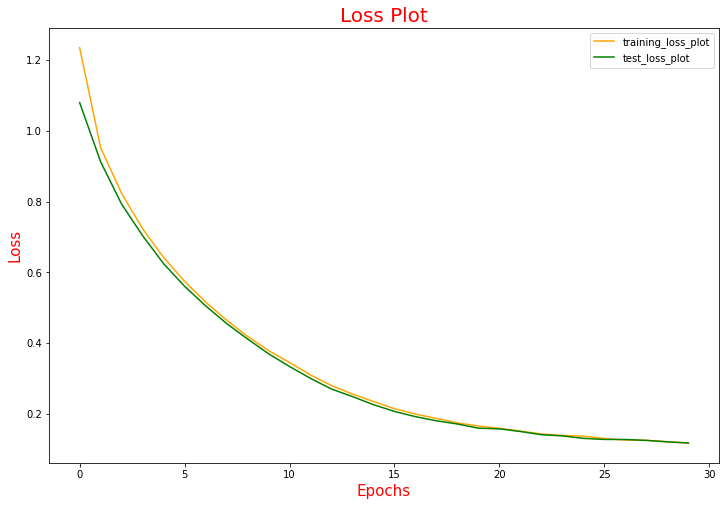

In [74]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

In [75]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [76]:
def plot_attention_map(caption, weights, image) :

  fig = plt.figure(figsize = (20, 20))
  temp_img = np.array(Image.open(image))
  #plt.imshow(temp_img)

  cap_len = len(caption)
  for cap in range(len(caption)) :
    weights_img = np.reshape(weights[cap], (7,7))
    

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap])

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gray', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [77]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [78]:
image_test = path_test_shot1.copy()

In [79]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [80]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [81]:
from nltk.translate.meteor_score import meteor_score

In [82]:
cap_test_data = caption_test.copy()
rid = np.random.randint(0, len(path_test))
test_image= path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
smooth = SmoothingFunction().method4
bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)
score = meteor_score(reference,candidate)
print('Meteor Score: %f' % np.mean(score))
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attention_map(result, attention_plot, test_image)

NameError: ignored

In [ ]:
b1=[]
b2=[]
b3=[]
b4=[]
m_score = []

for rid in range(0,len(path_test)):
  test_image= path_test[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
  result, attention_plot, pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)      
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()
  smooth = SmoothingFunction().method4
  bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
  bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
  bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
  bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
  b1.append(bleu1)
  b2.append(bleu2)
  b3.append(bleu3)
  b4.append(bleu4)
  score = meteor_score(reference,candidate)
  m_score.append(score)

In [ ]:
print('BLEU-1: %f' % np.mean(b1))
print('BLEU-2: %f' % np.mean(b2))
print('BLEU-3: %f' % np.mean(b3))
print('BLEU-4: %f' % np.mean(b4))

In [ ]:
print('Meteor Score of Bahdanau attention: %f' % np.mean(m_score))

# ZERO SHOT LEARNING

## Test with Bornon Dataset

In [83]:
train_captions_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_captions.pkl', 'rb'))
img_name_vector_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_img_names.pkl', 'rb'))

FileNotFoundError: ignored

In [ ]:
img_name_vector_bornon[:5]

## Tokenizer and Vocabulary (Bornon)

In [ ]:
import tensorflow as tf

In [84]:
bornon_train, bornon_test, bornon_cap_train, bornon_cap_test = train_test_split(img_name_vector_bornon, train_captions_bornon, test_size = 0.1, random_state = 42)

In [85]:
len(bornon_test)

2044

In [86]:
bornon_cap_test[:10]

['<start>    লাল শাড়ী পরা এক মহিলার ছবি দেখা যাচ্ছে   <end>',
 '<start>    গরু টানা লাঙ্গল দিয়ে ধানক্ষেত চাষ করা হচ্ছে   <end>',
 '<start>    সমুদ্রের নীল জল দেখা যাচ্ছে   <end>',
 '<start>    একটি পুকুরের ধারে দুটি গাছ আছে   <end>',
 '<start>    আমার বেলা যে যায় সাঁঝ বেলাতে তোমার সুরে সুরে সুর মেলাতে   <end>',
 '<start>    একটি সব্জির বাজার দেখা যাচ্ছে   <end>',
 '<start>    একটি বাদামি টিকটিকির পিছে সবুজ গাছ দেখা যাচ্ছে   <end>',
 '<start>    এক ধরনের পানিয় দেখা যাচ্ছে   <end>',
 '<start>    একজন বৃদ্ধ বসে নামাজ পড়ছে   <end>',
 '<start>    বড় বড় পাতা দেখা যাচ্ছে   <end>']

BLEU-1: 50.000000
BLEU-2: 31.622777
BLEU-3: 14.823518
BLEU-4: 10.754421
METEOR Score: 0.608466
Real Caption: একটি বাটি দেখা যাচ্ছে
Prediction Caption: একটি বাটিতে কাস্টার্ড এর দেখা যাচ্ছে


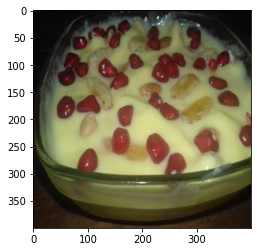

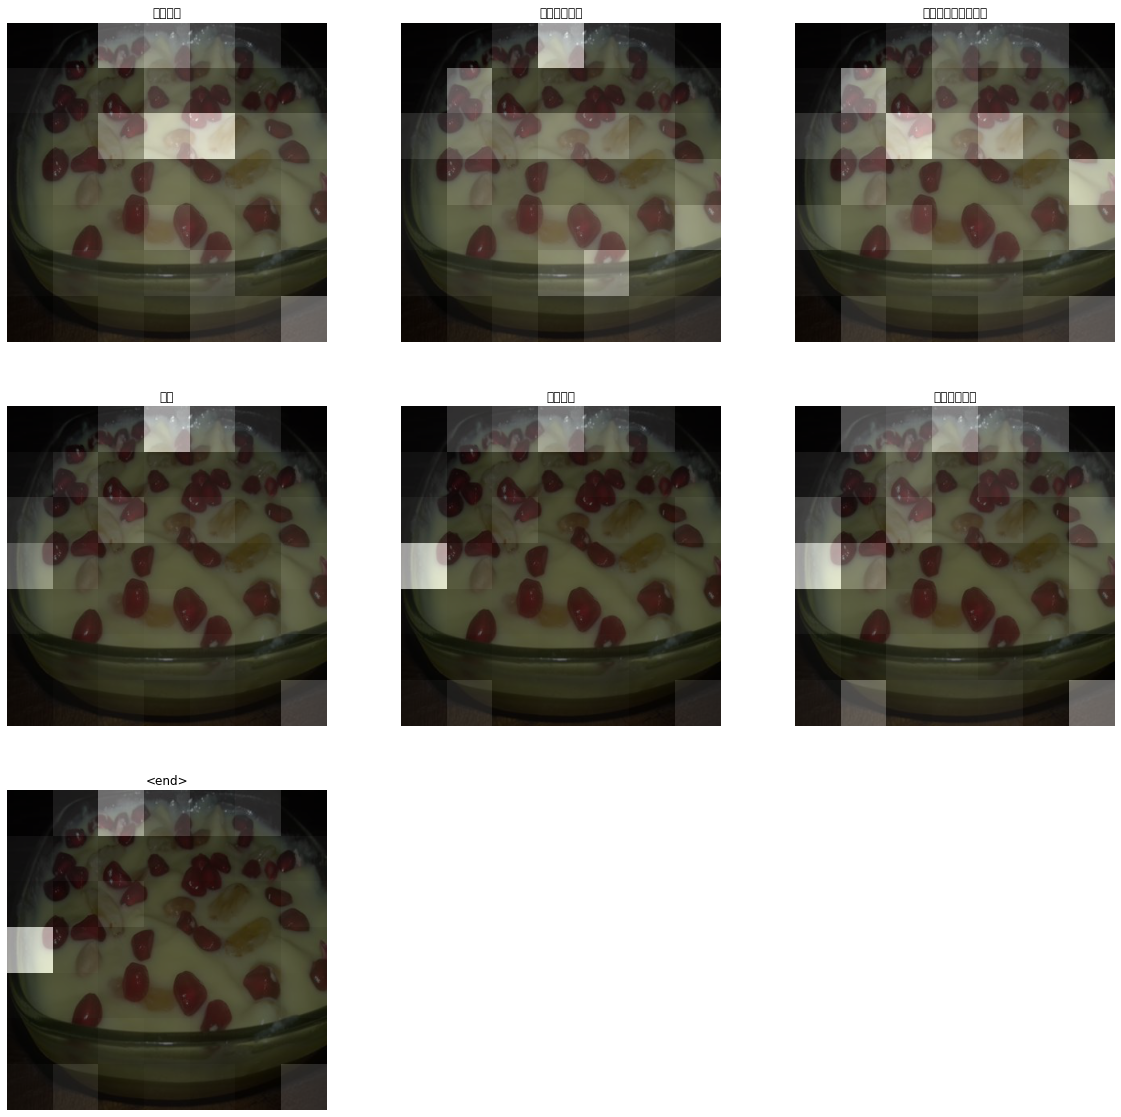

In [91]:
cap_test = bornon_cap_test.copy()
rid = np.random.randint(0, len(bornon_test))
test_image= bornon_test[rid]
real_caption = bornon_cap_test[rid]
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
temp_img = np.array(Image.open(test_image))
plt.imshow(temp_img)
smooth = SmoothingFunction().method4
bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)
score = meteor_score(reference,candidate)
print('METEOR Score: %f' % score)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attention_map(result, attention_plot, test_image)

In [92]:
b1_test=[]
b2_test=[]
b3_test=[]
b4_test=[]
m_test = []

for rid in range(0,len(bornon_cap_test)):
  test_image= bornon_test[rid]
  real_caption = bornon_cap_test[rid]
  result, attention_plot, pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)      
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()
  smooth = SmoothingFunction().method4
  bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
  bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
  bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
  bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
  b1_test.append(bleu1)
  b2_test.append(bleu2)
  b3_test.append(bleu3)
  b4_test.append(bleu4)
  score = meteor_score(reference,candidate)
  m_test.append(score)

In [95]:
# Zero shot result
print('BLEU-1: %f' % np.mean(b1_test))
print('BLEU-2: %f' % np.mean(b2_test))
print('BLEU-3: %f' % np.mean(b3_test))
print('BLEU-4: %f' % np.mean(b4_test))
print('Meteor Score of zero shot test 3: %f' % np.mean(m_test))

BLEU-1: 28.424800
BLEU-2: 18.867040
BLEU-3: 11.977699
BLEU-4: 9.444786
Meteor Score of zero shot test 3: 0.270991
